<a href="https://colab.research.google.com/github/RANJEET16520/Humour-Detection/blob/master/LSTM_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
 
import psutil
import humanize
import os
import GPUtil as GPU
 
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.7 GB  |     Proc size: 160.8 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total     11441MB


In [ ]:
import os
import math
import glob
import logging

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, matthews_corrcoef, confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
get_available_gpus()

Num GPUs Available:  1


['/device:GPU:0']

In [ ]:
train = pd.read_csv('/content/drive/My Drive/Data/New_200K_Jokes/train.csv')
train.shape

(160000, 2)

In [ ]:
dev = pd.read_csv('/content/drive/My Drive/Data/New_200K_Jokes/dev.csv')
dev.shape

(40000, 2)

In [ ]:
train.head()

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False


In [ ]:
train['number_of_words'] = train.text.apply(lambda x: len(x.split()))

In [ ]:
train.dtypes

text               object
humor                bool
number_of_words     int64
dtype: object

In [ ]:
dev.head()

,text,humor
0,What kind of cat should you take into the des...,True
1,Remember when people used to have to be in sha...,True
2,Pizza is always good. - everyone we'll see abo...,True
3,"What's 6 inches long hard, bent, and in my pan...",True
4,Black teen's response to violence in his commu...,False


In [ ]:
dev['number_of_words'] = dev.text.apply(lambda x: len(x.split()))

In [ ]:
dev.dtypes

text               object
humor                bool
number_of_words     int64
dtype: object

In [ ]:
def Visual(df):
    max_len = max(df.number_of_words)
    print('Length of Data = {}'.format(len(df)))
    print('No. of item with output 0 are = {}'.format(len(df[df['humor']==True])))
    print('No. of item with output 1 are = {}'.format(len(df[df['humor']==False]))) 
    print('Maximum length of a text in all texts = {}'.format(max_len)) 

In [ ]:
Visual(train)

Length of Data = 160000
No. of item with output 0 are = 79918
No. of item with output 1 are = 80082
Maximum length of a text in all texts = 18


In [ ]:
Visual(dev)

Length of Data = 40000
No. of item with output 0 are = 20082
No. of item with output 1 are = 19918
Maximum length of a text in all texts = 18


In [ ]:
!pip install transformers
from transformers import XLNetTokenizer

In [ ]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

In [ ]:
train_text_list = train["text"].values

In [ ]:
dev_text_list = dev["text"].values

In [ ]:
def tokenize_inputs(text_list, tokenizer, num_embeddings):
    """
    Tokenizes the input text input into ids. Appends the appropriate special
    characters to the end of the text to denote end of sentence. Truncate or pad
    the appropriate sequence length.
    """
    # tokenize the text, then truncate sequence to the desired length minus 2 for
    # the 2 special characters
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings-2], text_list))
    # convert tokenized text into numeric ids for the appropriate LM
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # append special token "<s>" and </s> to end of sentence
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    # pad sequences
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    input_ids = np.array(input_ids)
    return input_ids

In [ ]:
# create input id tokens
train_input_ids = tokenize_inputs(train_text_list, tokenizer, num_embeddings=50)
print(train_input_ids.shape)
train_input_ids

(160000, 50)


array([[   17,  2595,    93, ...,     0,     0,     0],
       [ 1628,    60,    17, ...,     0,     0,     0],
       [  113,   112,    44, ...,     0,     0,     0],
       ...,
       [  108,   886,   855, ...,     0,     0,     0],
       [   17,   150,    26, ...,     0,     0,     0],
       [ 2302, 10738,    61, ...,     0,     0,     0]])

In [ ]:
# create input id tokens
dev_input_ids = tokenize_inputs(dev_text_list, tokenizer, num_embeddings=50)
print(dev_input_ids.shape)
dev_input_ids

(40000, 50)


array([[  113,   713,    20, ...,     0,     0,     0],
       [ 1633,    90,   104, ...,     0,     0,     0],
       [12879,    27,   426, ...,     0,     0,     0],
       ...,
       [  160,   142,  8959, ...,     0,     0,     0],
       [   17,    98,   369, ...,     0,     0,     0],
       [   48,    17,  1121, ...,     0,     0,     0]])

In [ ]:
# add input ids and attention masks to the dataframe
train["features"] = train_input_ids.tolist()
train.head()

,text,humor,number_of_words,features
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False,10,"[17, 2595, 93, 2340, 254, 1414, 78, 15765, 234..."
1,Watch: darvish gave hitter whiplash with slow ...,False,8,"[1628, 60, 17, 5072, 25489, 675, 17, 11753, 14..."
2,What do you call a turtle without its shell? d...,True,10,"[113, 112, 44, 547, 24, 15700, 286, 81, 6197, ..."
3,5 reasons the 2016 election feels so personal,False,8,"[306, 2113, 18, 2884, 821, 4760, 102, 739, 4, ..."
4,"Pasco police shot mexican migrant from behind,...",False,10,"[943, 19301, 365, 938, 110, 6269, 2392, 21726,..."


In [ ]:
# add input ids and attention masks to the dataframe
dev["features"] = dev_input_ids.tolist()
dev.head()

,text,humor,number_of_words,features
0,What kind of cat should you take into the des...,True,16,"[113, 713, 20, 4777, 170, 44, 182, 91, 18, 567..."
1,Remember when people used to have to be in sha...,True,14,"[1633, 90, 104, 179, 22, 47, 22, 39, 25, 2787,..."
2,Pizza is always good. - everyone we'll see abo...,True,13,"[12879, 27, 426, 195, 9, 17, 13, 1251, 80, 26,..."
3,"What's 6 inches long hard, bent, and in my pan...",True,13,"[113, 26, 23, 284, 3763, 206, 500, 19, 9015, 1..."
4,Black teen's response to violence in his commu...,False,11,"[710, 8017, 26, 23, 1196, 22, 1350, 25, 45, 53..."


In [ ]:
X_train = train["features"].values.tolist()
X_valid = dev["features"].values.tolist()

label_cols = ["humor"]
Y_train = train[label_cols].values.tolist()
Y_valid = dev[label_cols].values.tolist()

In [ ]:
print('One Example of X_train:\n{}\n'.format(X_train[0]))
print('One Example of X_valid:\n{}\n'.format(X_valid[0]))

print('One Example of Y_train:\n{}\n'.format(Y_train[0]))
print('One Example of Y_valid:\n{}\n'.format(Y_valid[0]))

One Example of X_train:
[17, 2595, 93, 2340, 254, 1414, 78, 15765, 2340, 60, 17, 26, 3017, 117, 23, 19, 17, 150, 26, 98, 50, 926, 26, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

One Example of X_valid:
[113, 713, 20, 4777, 170, 44, 182, 91, 18, 5675, 17, 82, 24, 89, 1443, 8538, 982, 17, 136, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

One Example of Y_train:
[False]

One Example of Y_valid:
[True]



In [ ]:
X_train, X_valid, Y_train, Y_valid = np.array(X_train), np.array(X_valid), np.array(Y_train), np.array(Y_valid)
print(X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape)

(160000, 50) (40000, 50) (160000, 1) (40000, 1)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D

In [ ]:
model_joke = Sequential()
model_joke.add(Embedding(X_train.shape[0], X_train.shape[1], input_length=50, trainable=False))
model_joke.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_joke.add(Dense(256, activation='relu'))
model_joke.add(Dense(1, activation='sigmoid'))
model_joke.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_joke.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            8000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 8,086,513
Trainable params: 86,513
Non-trainable params: 8,000,000
_________________________________________________________________


In [ ]:
history = model_joke.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=5, batch_size=32, verbose=2)

Train on 160000 samples, validate on 40000 samples
Epoch 1/5
 - 687s - loss: 0.4579 - accuracy: 0.7601 - val_loss: 0.2454 - val_accuracy: 0.9106
Epoch 2/5
 - 676s - loss: 0.2453 - accuracy: 0.9094 - val_loss: 0.1827 - val_accuracy: 0.9356
Epoch 3/5
 - 679s - loss: 0.2031 - accuracy: 0.9278 - val_loss: 0.1673 - val_accuracy: 0.9401
Epoch 4/5
 - 683s - loss: 0.1865 - accuracy: 0.9334 - val_loss: 0.1653 - val_accuracy: 0.9391
Epoch 5/5
 - 679s - loss: 0.1739 - accuracy: 0.9377 - val_loss: 0.1544 - val_accuracy: 0.9460


In [ ]:
X_test, Y_test = X_valid, Y_valid

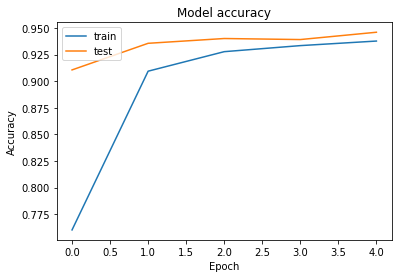

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')	
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

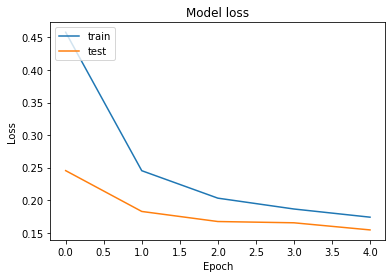

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
loss, acc = model_joke.evaluate(X_test, Y_test, verbose=0)
print('Test Accuracy: %f' % (acc*100))
print('Test Loss: %f' % (np.exp(loss)))

Test Accuracy: 94.602501
Test Loss: 1.166932


In [ ]:
from sklearn.metrics import accuracy_score, r2_score, f1_score, fbeta_score, precision_score, recall_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
Y_pred = model_joke.predict_classes(X_test)
for i in range(20):
	print('Actual = {}:, Predicted = {}'.format(Y_test[i], Y_pred[i]))

Actual = [ True]:, Predicted = [1]
Actual = [ True]:, Predicted = [0]
Actual = [ True]:, Predicted = [1]
Actual = [ True]:, Predicted = [1]
Actual = [False]:, Predicted = [0]
Actual = [False]:, Predicted = [0]
Actual = [ True]:, Predicted = [0]
Actual = [False]:, Predicted = [0]
Actual = [ True]:, Predicted = [1]
Actual = [ True]:, Predicted = [1]
Actual = [False]:, Predicted = [0]
Actual = [ True]:, Predicted = [1]
Actual = [ True]:, Predicted = [1]
Actual = [False]:, Predicted = [0]
Actual = [False]:, Predicted = [0]
Actual = [ True]:, Predicted = [1]
Actual = [ True]:, Predicted = [1]
Actual = [False]:, Predicted = [0]
Actual = [False]:, Predicted = [0]
Actual = [False]:, Predicted = [0]


In [ ]:
acc = accuracy_score(Y_test, Y_pred)
print("Accuracy : {}".format(acc))

Accuracy : 0.946025


In [ ]:
error = mean_absolute_error(Y_test, Y_pred)
print("Mean Absolute Error : {}".format(error))

Mean Absolute Error : 0.053975


In [ ]:
error = mean_squared_error(Y_test, Y_pred)
print("Mean Squared Error : {}".format(error))

Mean Squared Error : 0.053975


In [ ]:
score = r2_score(Y_test, Y_pred)
print("R2 Score : {}".format(score))

R2 Score : 0.7840963706599908


In [ ]:
score = precision_score(Y_test, Y_pred, average='macro')
print("Precision Score : {}".format(score))

Precision Score : 0.9465371888491569


In [ ]:
score = recall_score(Y_test, Y_pred, average='macro')
print("Recall Score : {}".format(score))

Recall Score : 0.9460973813969813


In [ ]:
score = f1_score(Y_test, Y_pred)
print("F1 Score : {}".format(score))

F1 Score : 0.9452711095338284


In [ ]:
score = fbeta_score(Y_test, Y_pred, beta = 0.5)
print("F-Beta Score : {}".format(score))

F-Beta Score : 0.9556637621732444


In [ ]:
jokes_roc = roc_auc_score(Y_test, Y_pred)
print('Jokes: ROC-Area Under Curve = {}'.format(jokes_roc))

Jokes: ROC-Area Under Curve = 0.9460973813969813


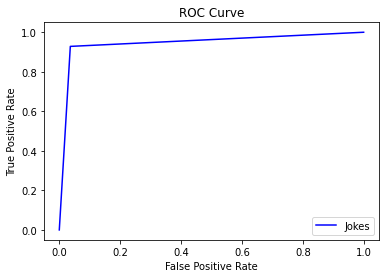

In [ ]:
J_fpr, J_tpr, _ = roc_curve(Y_test, Y_pred)
plt.plot(J_fpr, J_tpr, color = 'blue', label = 'Jokes')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()